In [15]:
import pandas as pd
from skimage.transform import rotate, rescale
import matplotlib.pyplot as plt
from matplotlib.path import Path
import fiona
import shapely.geometry as geometry
from shapely.geometry import Point
from shapely.affinity import rotate
from descartes import PolygonPatch
import pylab as pl
import multiprocessing as mp
import pathlib
import datetime
from src import *

np.random.seed(99)

Some examples of the random two-dimentional objects that we are going to use. They are generated by concave hulls of random points in the two-dimentional space.

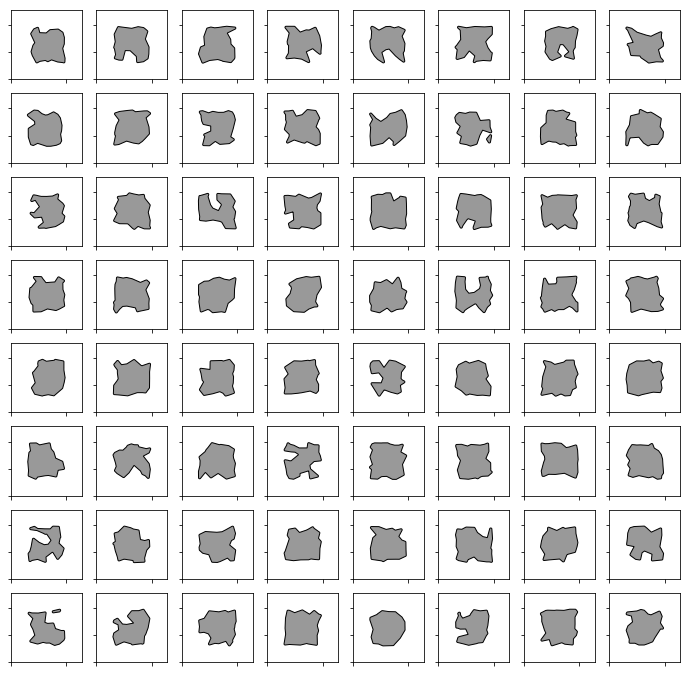

In [16]:
n_point = 60; alpha = .2
fig = pl.figure(figsize=(12,12))
for i in range(64):
    a = np.random.uniform(16,48,size=(n_point,2))
    points = [Point(a[i]) for i in range(n_point)]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)

    ax = fig.add_subplot(8,8,i+1)
    ax.set_yticklabels([]); 
    ax.set_xticklabels([])
    ax.set_xlim([0, 64]) #ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([0, 64])
    patch = PolygonPatch(concave_hull.buffer(1), fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)    

# Training and Evaluation

In [1]:
import numpy as np
import tensorflow as tf
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
import datetime
import matplotlib.pyplot as plt
from src import *

Model definitions

In [2]:
def dense(x, scope, num_h, n_x):
    """
    standard affine layer
    scope = name tf variable scope
    num_h = number of hidden units
    """
    with tf.variable_scope(scope):
        w = tf.get_variable('w', [n_x, num_h], initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [num_h], initializer=tf.constant_initializer(0))
        return tf.matmul(x, w)+b

def conv(x, scope, filter_h,filter_w, n_kernel, stride_h=1,stride_w=1, padding='SAME'):
    """
    Convolutional layer
    scope        = name tf variable scope
    filter_width = receptive field of kernel
    n_kernel     = # of kernels
    stride       = locations
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        n_x = x.get_shape().as_list()[-1]
        w = tf.get_variable('w',
                            [filter_h, filter_w, n_x, n_kernel],
                            initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [n_kernel], initializer=tf.constant_initializer(0))
        return tf.nn.convolution(x, w, padding=padding, strides=[stride_h, stride_w])+b    


def maxpool(X, scope, filter_h,filter_w, stride_h,stride_w, padding='VALID'):
    """
    Maxpool operation
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE) as scope:
        pool = tf.nn.max_pool(X, 
                            ksize=[1, filter_h, filter_w, 1], 
                            strides=[1, stride_h, stride_w, 1],
                            padding=padding)
    return pool    
    
def upsample(X, ratio=2):
    """
    Takes a 4D image tensor and increases spatial resolution by replicating values
    """
    n_h, n_w = X.get_shape().as_list()[1:3]
    return tf.image.resize_nearest_neighbor(X, [n_h*ratio, n_w*ratio])
    
    
def conv_1D_Images(X,batch_size,n_images, reuse=False):
    """
    Makes convolutions over 1D images  in a tensor of size 
    (batch_size,n_images, imgsize,1 ). Returns the average 
    values of the encodings of 1D images. 
    """

    with tf.variable_scope('convOneDImages', reuse=reuse):
        h = tf.nn.leaky_relu(conv(X, 'conv0',1,5,32,1,2), 0.1)    #32x32
        h = tf.nn.leaky_relu(conv(h, 'conv1', 1,3,64,1,1), 0.1)   #32x64
        h = maxpool(h,'pool1', 1,2,1,2,'VALID')                        #16x64
        h = tf.nn.leaky_relu(conv(h, 'conv2', 1,3,128,1,1), 0.1)  #16x128
        h = maxpool(h,'pool2', 1,2,1,2,'VALID')                        #8x128
        h = tf.nn.leaky_relu(conv(h, 'conv3', 1,3,256,1,1), 0.1)  #8x256
        h = maxpool(h,'pool3', 1,2,1,2,'VALID')                        #4x256
        h = tf.reshape(h, [batch_size*n_images, -1])
        
        h = tf.nn.leaky_relu(dense(h, 'fc_0', 512,4*256), 0.1)
        h = tf.nn.leaky_relu(dense(h, 'fc_1', 512,512), 0.1)
        h = tf.reshape(h, [batch_size, n_images, 512]) 

        h = tf.reduce_mean(h, 1)
        return h


def gen_2D_Obj(X, batch_size, enc_dim = 512, reuse=False):
    """
    Takes encoding produced by the 1D images as input and
    generates a 2D image of the object
    """
    with tf.variable_scope('2D_object_generator', reuse=reuse):
        h = tf.nn.leaky_relu(dense(X, 'hz', num_h=6*6*32,n_x=enc_dim), 0.1)
        h = tf.nn.leaky_relu(dense(h, 'hz1', num_h=6*6*128,n_x=6*6*32), 0.1)
        h = tf.reshape(h, [batch_size, 6, 6, 128]) 
        h = upsample(h)                                          #12x12x128
        h = tf.nn.leaky_relu(conv(h, 'h1', 3,3, n_kernel=64), 0.1)    #12x12x64
        h = upsample(h)                                          #24x24x64
        h = tf.nn.leaky_relu(conv(h, 'h2', 3,3, n_kernel=32), 0.1)    #24x24x32
        h = upsample(h)                                          #48x48x32
        h = tf.nn.leaky_relu(conv(h, 'h3', 3,3, n_kernel=16), 0.1)    #48x48x16
        h = conv(h, 'hx', 1,1,1)
        return h    
    

class objGenNetwork(object):
    """
    Implementation of the model
    """
    def __init__(self,
                 imgDim = 64,
                 o_imgDim = 48,
                 model_n_img_per_obj = 32,
                 noise = 0.5,
                 minibatchSize = 50,
                 testSampleSize = 1000,
                 lr = 0.001,
                 nProcess_dataprep = 4,
                 training = True,
                 shift_n = 8,
                 vers='v1'
                ):
        
        self.imgDim = imgDim
        self.o_imgDim = o_imgDim
        self.model_n_img_per_obj = model_n_img_per_obj
        self.noise = noise
        self.minibatchSize = minibatchSize
        self.testSampleSize = testSampleSize
        self.lr = lr
        self.nProcess_dataprep = nProcess_dataprep
        self.training = training
        self.shift_n = shift_n
        self.skip_step = 1
        self.vers = vers
        
        self.gstep = tf.Variable(0, 
                                 dtype=tf.int32, 
                                 trainable=False,
                                 name='global_step')
        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None

    def data_generator(self):

        """
        Generates batches of random objects and their 1D 
        density images from random rotations. Objects are 
        encoded in a NxN occupancy map, where the M[i,j] is
        1 if the object occupies the area between the coordinates
        (i,j),(i+1,j),(i,j+1),(i+1,j+1), and 0 otherwise. Gaussian
        noise with N(0,(self.noise)^2 ) is applied over 1D images.
        Additionally we shift 1D images randomly to left and right 
        by 8 pixels
        """
        nProcess_dataprep=self.nProcess_dataprep
        minibatchSize = self.minibatchSize
        testSampleSize = self.testSampleSize
        imgDim = self.imgDim
        o_imgDim = self.o_imgDim
        noise = self.noise
        model_n_img_per_obj=self.model_n_img_per_obj
        trainingBatch=True
        #shift_n = self.shift_n 
        #translations are done within the gen_rand_poly_images function
        
        batches = minibatchSize if trainingBatch else testSampleSize
        
        pool = mp.Pool(processes=nProcess_dataprep)
        results = pool.map(gen_rand_poly_images,[model_n_img_per_obj] * batches )
        pool.close(); pool.join()
        
        batch_x = np.expand_dims(np.array([k[1] for k in results],
                                          dtype='float32'),
                                 axis=3)
        batch_y = np.expand_dims(np.array([k[2] for k in results],
                                          dtype='float32'),
                                 axis=4)
        
        # add gaussian noise
        if(noise > 0):
            batch_x = batch_x + np.random.normal(0,noise,batch_x.shape)

        if trainingBatch:
            self.train_x_new = batch_x
            self.train_y_new = batch_y
        else:
            self.new_test_x = batch_x
            self.new_test_y = batch_y
        
        
    def inference(self):
        h = conv_1D_Images(self.x_ph, self.minibatchSize, self.model_n_img_per_obj)
        self.logits = gen_2D_Obj(h, self.minibatchSize)

        
    def loss(self):
        """
        Defines loss function
        We use cross entropy with logits over the pixels. Computes the minimum
        loss over all rotations
        """
        # 
        with tf.name_scope('loss'):
            tiled_logits = tf.tile(tf.expand_dims(self.logits, 1),[1,360,1,1,1])
            entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y_ph, logits=tiled_logits)
            entropy = tf.reduce_sum(entropy, axis = [2,3,4])
            entropy = tf.reduce_min(entropy,axis = 1)
            self.loss = tf.reduce_mean(entropy, name='loss')

    def optimize(self):
        """
        Optimization op
        """
        self.opt = tf.train.AdadeltaOptimizer(self.lr).minimize(self.loss, 
                                                global_step=self.gstep)

    def eval_graph(self):
        """
        Takes the most accurate rotation of the true object
        as reference and calculates the average accuracy of
        the occupancy grid of the object
        """
        with tf.name_scope('predict'):           
            self.predictions = tf.nn.sigmoid(self.logits)
        with tf.name_scope('prediction_eval'):
            tiledPreds = tf.tile(tf.expand_dims(self.predictions, 1),
                                 [1,360,1,1, 1])
            correctPreds = tf.equal(tf.round(tiledPreds),
                                    self.y_ph)
            hitsOnRotations = tf.reduce_sum(tf.cast(correctPreds,tf.float32),
                                            axis = [2,3,4])
            mostHits = tf.reduce_max(hitsOnRotations,axis=1)
            self.accuracy = tf.divide(tf.reduce_mean(mostHits),64.*64.)
        
        
    def eval_once(self, sess, writer, epoch, step):
        accuracy_batch, summaries = sess.run([self.accuracy,
                                              self.summary_op],
                                             feed_dict={self.x_ph: self.train_x_new,
                                                        self.y_ph: self.train_y_new})
        writer.add_summary(summaries, global_step=step)
        print('Accuracy at step {0}: {1} '.format(step,accuracy_batch))
        


    def summary(self):
        """
        Summary for TensorBoard
        """
        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.scalar('accuracy', self.accuracy)
            tf.summary.histogram('histogram loss', self.loss)
            self.summary_op = tf.summary.merge_all()

    def build(self):
        """
        Builds the computation graph
        """
        self.x_ph = tf.placeholder(tf.float32, [self.minibatchSize, 
                                                self.model_n_img_per_obj,
                                                self.imgDim,
                                                1]) 
        self.y_ph = tf.placeholder(tf.float32, [self.minibatchSize,
                                                360,
                                                self.o_imgDim,
                                                self.o_imgDim,
                                                1])
        self.data_generator()
        self.inference()
        self.loss()
        self.optimize()
        self.eval_graph()
        self.summary()
    
    def train_one_epoch(self, sess, saver, writer, epoch, step):
#        start_time = time.time()
        self.training = True
        _, l, summaries = sess.run([self.opt, 
                                    self.loss,
                                    self.summary_op],
                                   feed_dict={self.x_ph: self.train_x_new,
                                              self.y_ph: self.train_y_new})
        writer.add_summary(summaries, global_step=step)
        if (step + 1) % self.skip_step == 0:
            print('Loss at step {0}: {1}'.format(step, l))
        step += 1
        saver.save(sess, 'checkpoints/cryoem/cryoem_'+self.vers, step)
#        print('Average loss at epoch {0}: {1}'.format(epoch, l))
#        print('Took: {0} seconds'.format(time.time() - start_time))
        return step

    def train(self, n_epochs):
        """
        We prepare the training data in a paralel process during training.
        When the next batch is ready, it is first used as a test data, and
        we report the prediction accuracy over that batch. Afterwards this
        new batch is used for training
        """
        safe_mkdir('checkpoints')
        safe_mkdir('checkpoints/cryoem_adadelta')
        writer = tf.summary.FileWriter('./graphs/cryoem_'+self.vers, tf.get_default_graph())

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem_adadelta/cryoem_'+self.vers))
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
            
            step = self.gstep.eval()

            for epoch in range(n_epochs):
                self.train_x = self.train_x_new
                self.train_y = self.train_y_new

                pool = ThreadPool(processes=1)
                async_result = pool.apply_async(self.data_generator,())
                step = self.train_one_epoch(sess, saver, writer, epoch, step)
                pool.close()
                pool.join()
                self.eval_once(sess, writer, epoch, step)
                
               # y_pred = sess.run(self.predictions,feed_dict={self.x_ph: self.train_x_new})
               # plt.imsave('0true.png',self.train_y_new[5][0][:,:,0])
               # plt.imsave('0pred.png',y_pred[5,:,:,0]>0.5)
               # plt.imsave('1true.png',self.train_y_new[6][0][:,:,0])
               # plt.imsave('1pred.png',y_pred[6,:,:,0]>0.5)
                
        writer.close()


In [3]:
# Note that the data generation process would utilize 4 CPU
# threads. If the model would train on GPU, you may set the
# 'nProcess_dataprep' argument equal to 'mp.cpu_count()'
model = objGenNetwork(noise=0,model_n_img_per_obj=64, lr=1,nProcess_dataprep=4, vers='sigma0')
model.build()


INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [4]:
# training
model.train(n_epochs=50)

Loss at step 0: 1596.9141845703125
Accuracy at step 1: 0.49705079197883606 
Loss at step 1: 1594.97998046875
Accuracy at step 2: 0.5083593726158142 
Loss at step 2: 1585.26708984375
Accuracy at step 3: 0.5082421898841858 
Loss at step 3: 1526.8699951171875
Accuracy at step 4: 0.512158215045929 
Loss at step 4: 1113.150146484375
Accuracy at step 5: 0.5102783441543579 
Loss at step 5: 824.8446044921875
Accuracy at step 6: 0.38819336891174316 
Loss at step 6: 1110.2320556640625
Accuracy at step 7: 0.4976855516433716 
Loss at step 7: 665.203369140625
Accuracy at step 8: 0.44819337129592896 
Loss at step 8: 1426.599365234375
Accuracy at step 9: 0.5086279511451721 
Loss at step 9: 1215.6878662109375
Accuracy at step 10: 0.5098535418510437 
Loss at step 10: 563.6553344726562
Accuracy at step 11: 0.516894519329071 
Loss at step 11: 470.4573059082031
Accuracy at step 12: 0.5219433307647705 
Loss at step 12: 462.79522705078125
Accuracy at step 13: 0.5221777558326721 
Loss at step 13: 403.3318786

INFO:tensorflow:Restoring parameters from checkpoints/cryoem/cryoem_sigma0-50


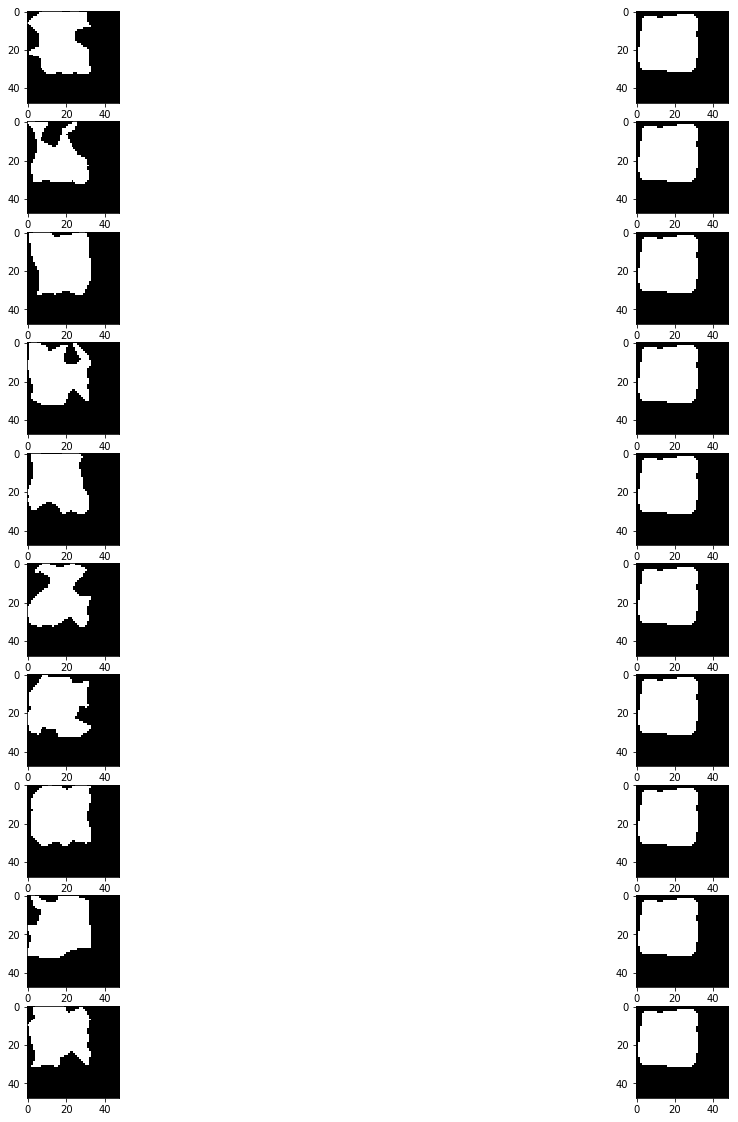

In [14]:
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem/cryoem_sigma1'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    y_pred = sess.run(model.predictions,feed_dict={model.x_ph: model.train_x_new})



fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 5
for i in range(0, 10):
    fig.add_subplot(10, 2, i*2+1)
    plt.imshow(model.train_y_new[i][0][:,:,0],interpolation='nearest', cmap="gray")
    
    fig.add_subplot(10, 2, i*2+2)
    plt.imshow(y_pred[i,:,:,0]>0.5,interpolation='nearest', cmap="gray")
plt.show()
